In [2]:
import kagglehub
from glob import glob
from pathlib import Path
from utils.image_utils import Image_Processing
from utils.data_loaders import Loaders
from utils.training import Trainer
from utils.audio_utils import MFCCFeatureExtractor
from utils.audio_utils import AudioDataset
from utils.plotting import plot_history
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torchvision
from models.net1 import Net1
from models.net2 import Net2
from models.net3 import Net3
from models.net5 import Net5
from models.CGANGenerator import Generator
from models.CGANDiscriminator import Discriminator
from torch.utils.data import  DataLoader
from utils.model_eval import evaluate
import warnings
warnings.filterwarnings("ignore")
import numpy as np

In [2]:
# This block of code prepares the GTZAN dataset by identifying the base path,
# then retrieving all audio file paths and the image directory.
#
# - path points to the KaggleHub download cache of the GTZAN dataset.
# - BASE_DIR navigates one level deeper into the dataset version folder.
# - audio_paths collects full paths to all WAV files inside genre folders.
path = Path("/home/awr1u24/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1")
if not path.exists():
    print("[INFO] GTZAN dataset not found locally. Downloading from KaggleHub...")
    path = Path(kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification"))
    print("[INFO] Dataset downloaded to:", path)

try:
    BASE_DIR = next(path.iterdir())
except StopIteration:
    raise FileNotFoundError(f"[ERROR] No contents found inside {path}.")

audio_paths = glob(str(BASE_DIR / "genres_original" / "*" / "*.wav"))
if not audio_paths:
    raise FileNotFoundError(f"[ERROR] No audio files found in {BASE_DIR}/genres_original/.")

image_dirs = glob(str(BASE_DIR / "images_original"))
if not image_dirs:
    raise FileNotFoundError(f"[ERROR] No image directory found at {BASE_DIR}/images_original.")

image_dir = image_dirs[0]

print(f"[SUCCESS] Loaded {len(audio_paths)} audio files.")
print(f"[SUCCESS] Spectrograms directory located at: {image_dir}")

[SUCCESS] Loaded 1000 audio files.
[SUCCESS] Spectrograms directory located at: /home/awr1u24/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/images_original


# 1-4 architecture 

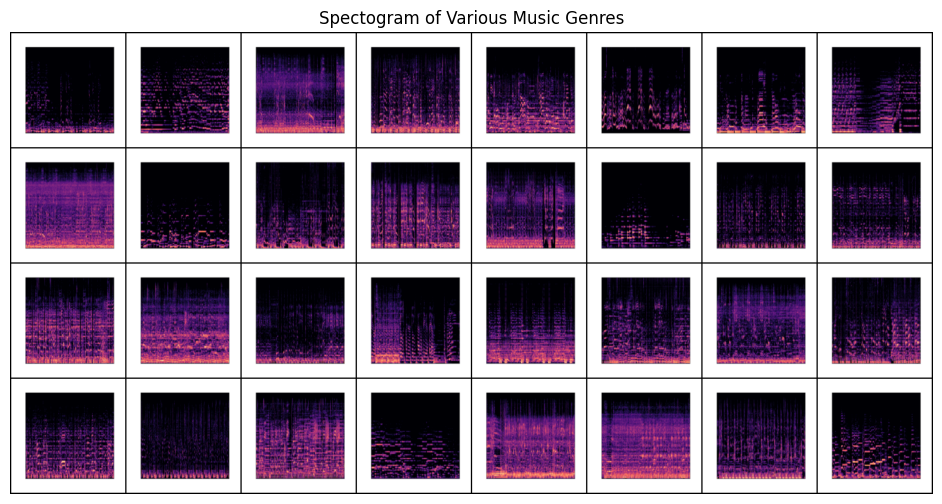

In [3]:
image_dataset = Image_Processing(image_dir)
image_train_loaders, image_val_loaders, image_test_loaders = Loaders(image_dataset, batch_size=32)

# Function to display a batch of spectrogram images in a grid format
# Useful for visually inspecting the dataset and verifying correct preprocessing
def show_image_batch(images, labels):
    grid_img = torchvision.utils.make_grid(images, nrow=8)
    plt.figure(figsize=(12, 6))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title("Spectogram of Various Music Genres")
    plt.axis('off')
    plt.show()

for images, labels in image_train_loaders:
    show_image_batch(images, labels)
    break

In [ ]:
trainer = Trainer(
    train_loader=image_train_loaders,
    val_loader=image_val_loaders,
    device=torch.device("cuda"),
    save_dir=Path("./checkpoints"),
)

#result_1_4 meaning that the result for architecture 1 to 4
results_1_4 = []

for epoch in [50, 100]:
    for optimizer, opt_params in [
        (optim.RMSprop, {"lr": 1e-4}),
        (optim.Adam, {"lr": 1e-4}),
    ]:
        if optimizer == optim.RMSprop:
            models = {
                "Net1": lambda: Net1(
                    input_size=3*180*180, 
                    hidden_size1=512,
                    hidden_size2=512,
                    output_size=10,
                ),
                "Net2": lambda: Net2(),
                "Net4": lambda: Net3(),
            }
        else:
            models = {
                 
                "Net1": lambda: Net1(
                    input_size=3*180*180, 
                    hidden_size1=512,
                    hidden_size2=512,
                    output_size=10,
                ),
                "Net2": lambda: Net2(),
                "Net3": lambda: Net3(),
            }

        result = trainer.train_models(
            models=models,
            epochs=[epoch],
            optimizers=[(optimizer, opt_params)],
        )
        results_1_4.append(result)

[INFO] Training: Net1 | Epochs: 50 | Optimizer: RMSprop | Config: {'lr': 0.0001}


Epoch 10/50 | Train Loss: 1.8633 | Train Acc: 0.3219 | Val Loss: 1.9096 | Val Acc: 0.2312


Epoch 20/50 | Train Loss: 1.5819 | Train Acc: 0.4464 | Val Loss: 2.0292 | Val Acc: 0.2814


Epoch 30/50 | Train Loss: 1.2707 | Train Acc: 0.5522 | Val Loss: 1.7819 | Val Acc: 0.4221


Epoch 40/50 | Train Loss: 1.1113 | Train Acc: 0.6338 | Val Loss: 1.5834 | Val Acc: 0.4472


Epoch 50/50 | Train Loss: 0.9392 | Train Acc: 0.6652 | Val Loss: 1.5155 | Val Acc: 0.4824
[INFO] Saved: checkpoints/Net1_RMSprop_epoch50.pt
[INFO] Training: Net2 | Epochs: 50 | Optimizer: RMSprop | Config: {'lr': 0.0001}


Epoch 10/50 | Train Loss: 1.0495 | Train Acc: 0.6409 | Val Loss: 1.4033 | Val Acc: 0.4975


Epoch 20/50 | Train Loss: 0.2676 | Train Acc: 0.9256 | Val Loss: 1.4974 | Val Acc: 0.5075


Epoch 30/50 | Train Loss: 0.0362 | Train Acc: 0.9943 | Val Loss: 1.9896 | Val Acc: 0.4724


Epoch 40/50 | Train Loss: 0.0133 | Train Acc: 0.9986 | Val Loss: 1.9795 | Val Acc: 0.5578


Epoch 50/50 | Train Loss: 0.0143 | Train Acc: 0.9971 | Val Loss: 2.1077 | Val Acc: 0.5578
[INFO] Saved: checkpoints/Net2_RMSprop_epoch50.pt
[INFO] Training: Net4 | Epochs: 50 | Optimizer: RMSprop | Config: {'lr': 0.0001}


Epoch 10/50 | Train Loss: 0.1916 | Train Acc: 0.9714 | Val Loss: 1.3786 | Val Acc: 0.5276


Epoch 20/50 | Train Loss: 0.0442 | Train Acc: 0.9943 | Val Loss: 1.3996 | Val Acc: 0.5829


Epoch 30/50 | Train Loss: 0.0219 | Train Acc: 0.9986 | Val Loss: 1.4230 | Val Acc: 0.5628


Epoch 40/50 | Train Loss: 0.0437 | Train Acc: 0.9928 | Val Loss: 1.6539 | Val Acc: 0.5930


Epoch 50/50 | Train Loss: 0.0232 | Train Acc: 0.9971 | Val Loss: 1.7281 | Val Acc: 0.5628
[INFO] Saved: checkpoints/Net4_RMSprop_epoch50.pt
[INFO] Training: Net1 | Epochs: 50 | Optimizer: Adam | Config: {'lr': 0.0001}


Epoch 10/50 | Train Loss: 1.5977 | Train Acc: 0.4464 | Val Loss: 1.7560 | Val Acc: 0.3719


Epoch 20/50 | Train Loss: 1.1733 | Train Acc: 0.6323 | Val Loss: 1.8037 | Val Acc: 0.3367


Epoch 30/50 | Train Loss: 0.7528 | Train Acc: 0.7783 | Val Loss: 1.6330 | Val Acc: 0.4472


Epoch 40/50 | Train Loss: 0.5007 | Train Acc: 0.8784 | Val Loss: 1.7283 | Val Acc: 0.4070


Epoch 50/50 | Train Loss: 0.2308 | Train Acc: 0.9700 | Val Loss: 1.7978 | Val Acc: 0.4573
[INFO] Saved: checkpoints/Net1_Adam_epoch50.pt
[INFO] Training: Net2 | Epochs: 50 | Optimizer: Adam | Config: {'lr': 0.0001}


Epoch 10/50 | Train Loss: 1.5513 | Train Acc: 0.4592 | Val Loss: 1.6872 | Val Acc: 0.3869


Epoch 20/50 | Train Loss: 0.6584 | Train Acc: 0.7969 | Val Loss: 1.3629 | Val Acc: 0.5226


Epoch 30/50 | Train Loss: 0.1966 | Train Acc: 0.9557 | Val Loss: 1.5750 | Val Acc: 0.5528


Epoch 40/50 | Train Loss: 0.0360 | Train Acc: 0.9971 | Val Loss: 2.1248 | Val Acc: 0.5327


Epoch 50/50 | Train Loss: 0.0151 | Train Acc: 0.9986 | Val Loss: 2.2057 | Val Acc: 0.5678
[INFO] Saved: checkpoints/Net2_Adam_epoch50.pt
[INFO] Training: Net3 | Epochs: 50 | Optimizer: Adam | Config: {'lr': 0.0001}


Epoch 10/50 | Train Loss: 0.0170 | Train Acc: 0.9986 | Val Loss: 1.1702 | Val Acc: 0.6030


Epoch 20/50 | Train Loss: 0.0099 | Train Acc: 0.9986 | Val Loss: 1.2087 | Val Acc: 0.6030


Epoch 30/50 | Train Loss: 0.0053 | Train Acc: 0.9986 | Val Loss: 1.2721 | Val Acc: 0.5829


Epoch 40/50 | Train Loss: 0.0160 | Train Acc: 0.9986 | Val Loss: 1.5242 | Val Acc: 0.5628


Epoch 50/50 | Train Loss: 0.0052 | Train Acc: 0.9971 | Val Loss: 1.2407 | Val Acc: 0.6080
[INFO] Saved: checkpoints/Net3_Adam_epoch50.pt
[INFO] Training: Net1 | Epochs: 100 | Optimizer: RMSprop | Config: {'lr': 0.0001}


Epoch 10/100 | Train Loss: 1.8341 | Train Acc: 0.3419 | Val Loss: 1.8937 | Val Acc: 0.2663


Epoch 20/100 | Train Loss: 1.5481 | Train Acc: 0.4406 | Val Loss: 1.9305 | Val Acc: 0.2563


Epoch 30/100 | Train Loss: 1.2503 | Train Acc: 0.5508 | Val Loss: 1.6462 | Val Acc: 0.4523


Epoch 40/100 | Train Loss: 1.0311 | Train Acc: 0.6452 | Val Loss: 1.6174 | Val Acc: 0.4372


Epoch 50/100 | Train Loss: 0.8877 | Train Acc: 0.6924 | Val Loss: 1.9509 | Val Acc: 0.3920


Epoch 60/100 | Train Loss: 0.7460 | Train Acc: 0.7539 | Val Loss: 2.3342 | Val Acc: 0.3417


Epoch 70/100 | Train Loss: 0.6493 | Train Acc: 0.7897 | Val Loss: 2.6249 | Val Acc: 0.3970


Epoch 80/100 | Train Loss: 0.3721 | Train Acc: 0.9027 | Val Loss: 1.7912 | Val Acc: 0.4422


Epoch 90/100 | Train Loss: 0.3071 | Train Acc: 0.9099 | Val Loss: 1.9438 | Val Acc: 0.4623


Epoch 100/100 | Train Loss: 0.2343 | Train Acc: 0.9442 | Val Loss: 1.6499 | Val Acc: 0.5025
[INFO] Saved: checkpoints/Net1_RMSprop_epoch100.pt
[INFO] Training: Net2 | Epochs: 100 | Optimizer: RMSprop | Config: {'lr': 0.0001}


Epoch 10/100 | Train Loss: 1.2218 | Train Acc: 0.5894 | Val Loss: 1.4775 | Val Acc: 0.4070


Epoch 20/100 | Train Loss: 0.5919 | Train Acc: 0.8183 | Val Loss: 1.2638 | Val Acc: 0.5829


Epoch 30/100 | Train Loss: 0.1950 | Train Acc: 0.9471 | Val Loss: 1.5214 | Val Acc: 0.5427


Epoch 40/100 | Train Loss: 0.0437 | Train Acc: 0.9928 | Val Loss: 1.6617 | Val Acc: 0.5779


Epoch 50/100 | Train Loss: 0.0239 | Train Acc: 0.9971 | Val Loss: 1.7620 | Val Acc: 0.5678


Epoch 60/100 | Train Loss: 0.0135 | Train Acc: 0.9971 | Val Loss: 2.1184 | Val Acc: 0.5477


Epoch 70/100 | Train Loss: 0.0147 | Train Acc: 0.9971 | Val Loss: 1.9844 | Val Acc: 0.5528


Epoch 80/100 | Train Loss: 0.0106 | Train Acc: 0.9971 | Val Loss: 1.9189 | Val Acc: 0.5729


Epoch 90/100 | Train Loss: 0.0175 | Train Acc: 0.9971 | Val Loss: 1.9145 | Val Acc: 0.5427


Epoch 100/100 | Train Loss: 0.0132 | Train Acc: 0.9971 | Val Loss: 2.0391 | Val Acc: 0.5528
[INFO] Saved: checkpoints/Net2_RMSprop_epoch100.pt
[INFO] Training: Net4 | Epochs: 100 | Optimizer: RMSprop | Config: {'lr': 0.0001}


Epoch 10/100 | Train Loss: 0.3895 | Train Acc: 0.8870 | Val Loss: 1.2563 | Val Acc: 0.5678


Epoch 20/100 | Train Loss: 0.0467 | Train Acc: 0.9971 | Val Loss: 1.4562 | Val Acc: 0.5879


Epoch 30/100 | Train Loss: 0.0317 | Train Acc: 0.9971 | Val Loss: 1.4154 | Val Acc: 0.6382


Epoch 40/100 | Train Loss: 0.0111 | Train Acc: 0.9971 | Val Loss: 1.5554 | Val Acc: 0.6482


Epoch 50/100 | Train Loss: 0.0246 | Train Acc: 0.9957 | Val Loss: 1.4711 | Val Acc: 0.6332


Epoch 60/100 | Train Loss: 0.0339 | Train Acc: 0.9943 | Val Loss: 1.5456 | Val Acc: 0.6080


Epoch 70/100 | Train Loss: 0.0214 | Train Acc: 0.9986 | Val Loss: 2.0258 | Val Acc: 0.6281


Epoch 80/100 | Train Loss: 0.0299 | Train Acc: 0.9971 | Val Loss: 2.0970 | Val Acc: 0.6332


Epoch 90/100 | Train Loss: 0.0072 | Train Acc: 0.9986 | Val Loss: 1.9930 | Val Acc: 0.6281


Epoch 100/100 | Train Loss: 0.0234 | Train Acc: 0.9986 | Val Loss: 2.7447 | Val Acc: 0.5779
[INFO] Saved: checkpoints/Net4_RMSprop_epoch100.pt
[INFO] Training: Net1 | Epochs: 100 | Optimizer: Adam | Config: {'lr': 0.0001}


Epoch 10/100 | Train Loss: 1.5902 | Train Acc: 0.4521 | Val Loss: 1.7496 | Val Acc: 0.3920


Epoch 20/100 | Train Loss: 1.0864 | Train Acc: 0.6237 | Val Loss: 1.7776 | Val Acc: 0.3618


Epoch 30/100 | Train Loss: 0.7346 | Train Acc: 0.7811 | Val Loss: 1.7130 | Val Acc: 0.4874


Epoch 40/100 | Train Loss: 0.4029 | Train Acc: 0.9013 | Val Loss: 1.5511 | Val Acc: 0.4372


Epoch 50/100 | Train Loss: 0.1915 | Train Acc: 0.9800 | Val Loss: 1.5614 | Val Acc: 0.4874


Epoch 60/100 | Train Loss: 0.1460 | Train Acc: 0.9814 | Val Loss: 2.1594 | Val Acc: 0.4121


Epoch 70/100 | Train Loss: 0.0636 | Train Acc: 0.9971 | Val Loss: 1.7288 | Val Acc: 0.5226


Epoch 80/100 | Train Loss: 0.0368 | Train Acc: 0.9971 | Val Loss: 1.7605 | Val Acc: 0.5276


Epoch 90/100 | Train Loss: 0.0246 | Train Acc: 0.9986 | Val Loss: 1.8216 | Val Acc: 0.5126


Epoch 100/100 | Train Loss: 0.0354 | Train Acc: 0.9957 | Val Loss: 2.2405 | Val Acc: 0.4422
[INFO] Saved: checkpoints/Net1_Adam_epoch100.pt
[INFO] Training: Net2 | Epochs: 100 | Optimizer: Adam | Config: {'lr': 0.0001}


Epoch 10/100 | Train Loss: 1.7107 | Train Acc: 0.3763 | Val Loss: 1.7714 | Val Acc: 0.3417


Epoch 20/100 | Train Loss: 0.8770 | Train Acc: 0.7153 | Val Loss: 1.5689 | Val Acc: 0.4975


Epoch 30/100 | Train Loss: 0.1821 | Train Acc: 0.9628 | Val Loss: 1.6939 | Val Acc: 0.5126


Epoch 40/100 | Train Loss: 0.0244 | Train Acc: 0.9986 | Val Loss: 2.1955 | Val Acc: 0.5377


Epoch 50/100 | Train Loss: 0.0177 | Train Acc: 0.9971 | Val Loss: 2.1366 | Val Acc: 0.5678


Epoch 60/100 | Train Loss: 0.0200 | Train Acc: 0.9971 | Val Loss: 2.5320 | Val Acc: 0.5025


Epoch 70/100 | Train Loss: 0.0092 | Train Acc: 0.9986 | Val Loss: 2.3932 | Val Acc: 0.5729


Epoch 80/100 | Train Loss: 0.0183 | Train Acc: 0.9971 | Val Loss: 2.3093 | Val Acc: 0.5477


Epoch 90/100 | Train Loss: 0.0099 | Train Acc: 0.9986 | Val Loss: 2.3146 | Val Acc: 0.5678


Epoch 100/100 | Train Loss: 0.0113 | Train Acc: 0.9986 | Val Loss: 2.3776 | Val Acc: 0.5377
[INFO] Saved: checkpoints/Net2_Adam_epoch100.pt
[INFO] Training: Net3 | Epochs: 100 | Optimizer: Adam | Config: {'lr': 0.0001}


Epoch 10/100 | Train Loss: 0.0358 | Train Acc: 0.9971 | Val Loss: 1.2678 | Val Acc: 0.6030


Epoch 20/100 | Train Loss: 0.0189 | Train Acc: 0.9986 | Val Loss: 1.4725 | Val Acc: 0.5578


Epoch 30/100 | Train Loss: 0.0354 | Train Acc: 0.9957 | Val Loss: 1.5814 | Val Acc: 0.5678


Epoch 40/100 | Train Loss: 0.0267 | Train Acc: 0.9986 | Val Loss: 1.5347 | Val Acc: 0.5779


Epoch 50/100 | Train Loss: 0.0172 | Train Acc: 0.9986 | Val Loss: 1.6795 | Val Acc: 0.5427


Epoch 60/100 | Train Loss: 0.0259 | Train Acc: 0.9971 | Val Loss: 1.3316 | Val Acc: 0.6131


Epoch 70/100 | Train Loss: 0.0196 | Train Acc: 0.9986 | Val Loss: 1.3154 | Val Acc: 0.6080


Epoch 80/100 | Train Loss: 0.0041 | Train Acc: 0.9986 | Val Loss: 1.3725 | Val Acc: 0.6030


Epoch 90/100 | Train Loss: 0.0222 | Train Acc: 0.9986 | Val Loss: 1.3793 | Val Acc: 0.5930


Epoch 100/100 | Train Loss: 0.0289 | Train Acc: 0.9957 | Val Loss: 2.6751 | Val Acc: 0.4724
[INFO] Saved: checkpoints/Net3_Adam_epoch100.pt


<Figure size 1200x600 with 0 Axes>

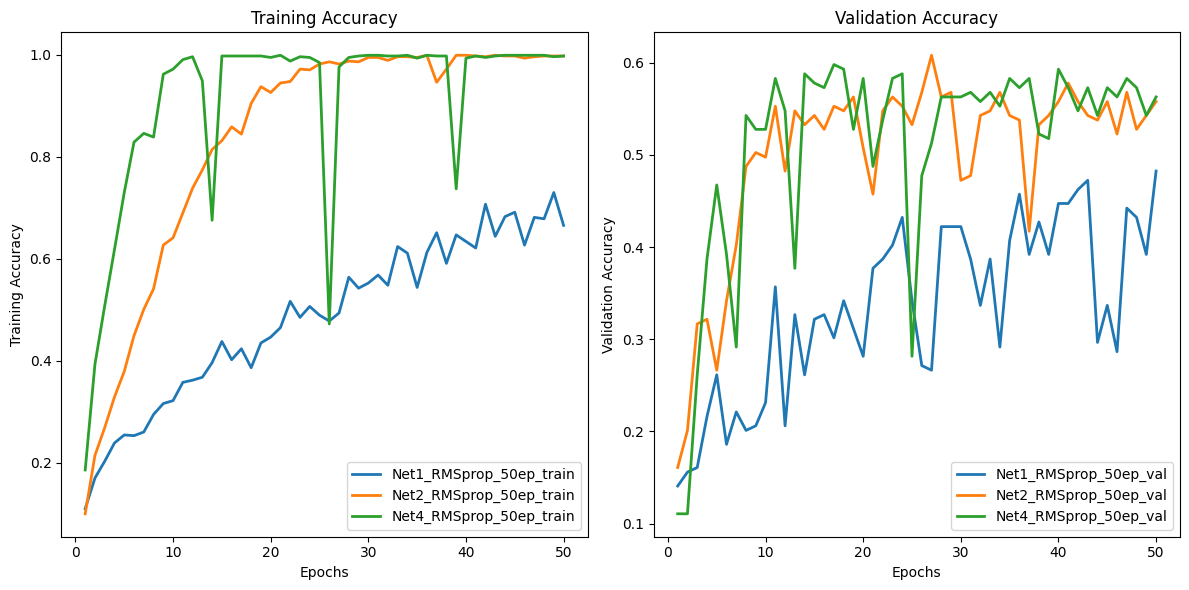

In [6]:
#result_1_4 meaning that the result for architecture 1 to 4
plot_history(results_1_4[0]) #Training Vs Validation Accuracy

<Figure size 1200x600 with 0 Axes>

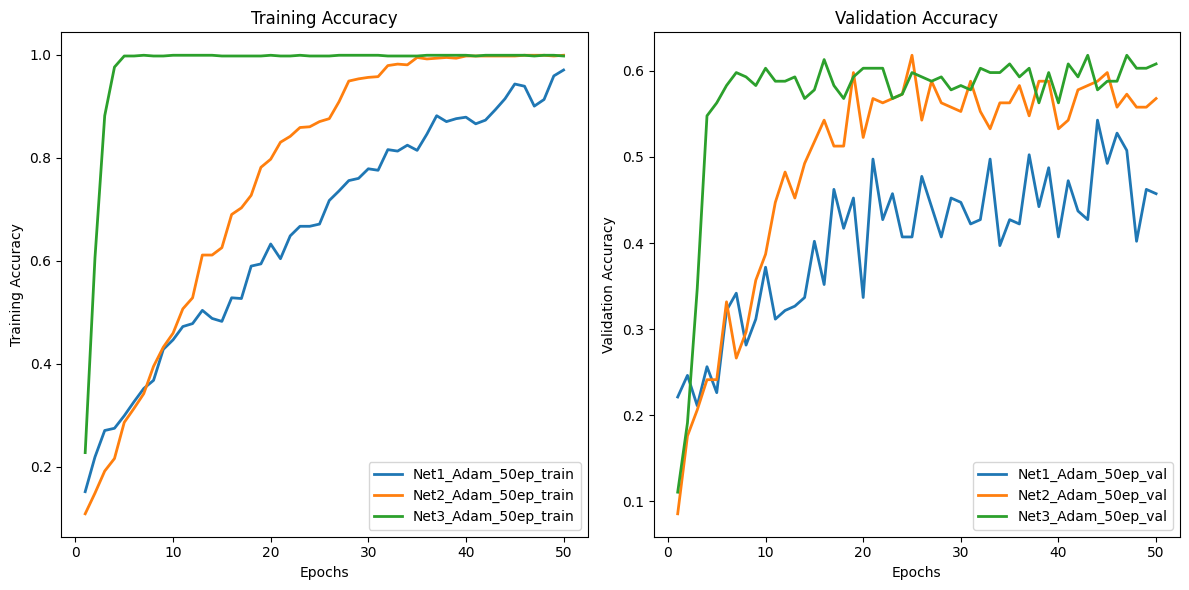

In [7]:
plot_history(results_1_4[1])  #Training Vs Validation Accuracy

<Figure size 1200x600 with 0 Axes>

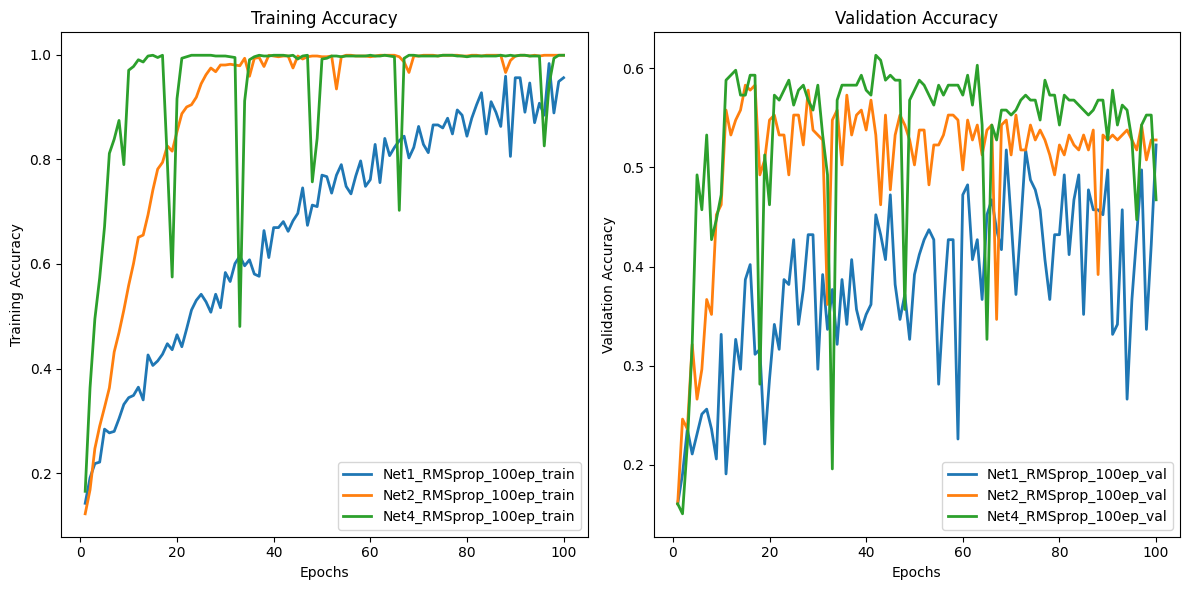

In [ ]:
plot_history(results_1_4[2])  #Training Vs Validation Accuracy

<Figure size 1200x600 with 0 Axes>

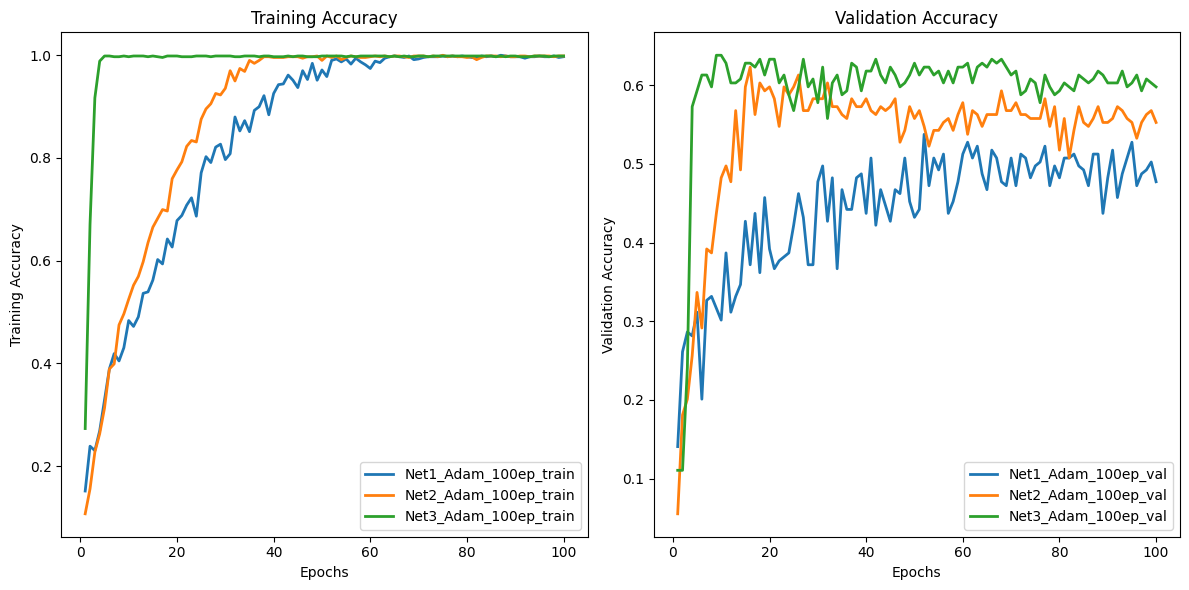

In [26]:
plot_history(results_1_4[3])  #Training Vs Validation Accuracy

<Figure size 1200x600 with 0 Axes>

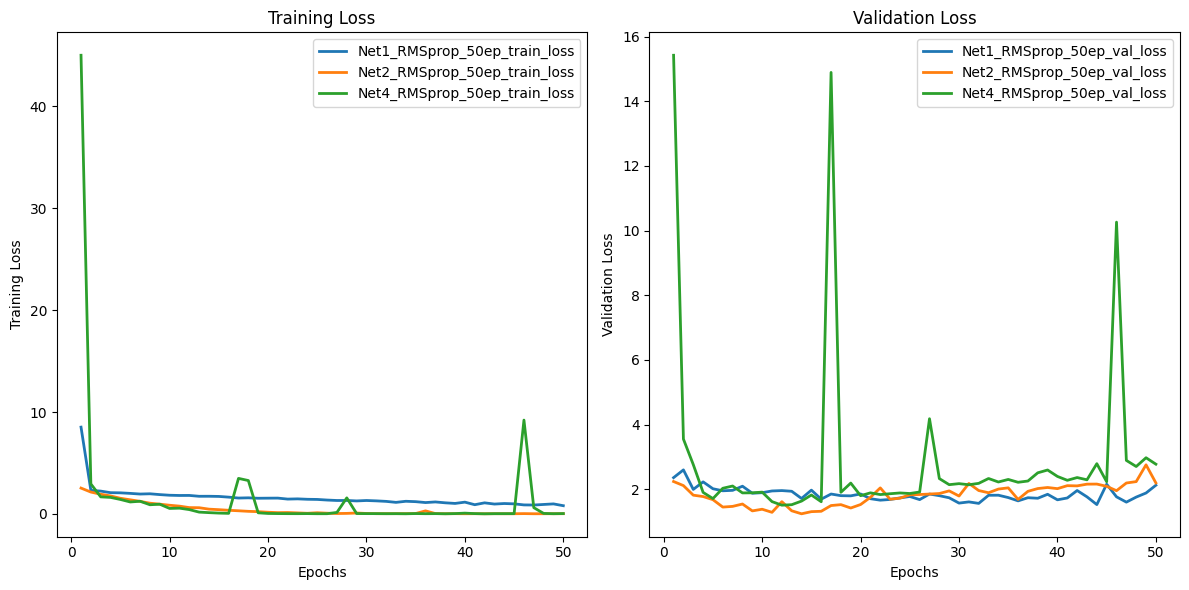

In [12]:
#result_arr14 meaning that the result for architecture 1 to 4
plot_history(results_1_4[0], accuracy=False, loss=True)

<Figure size 1200x600 with 0 Axes>

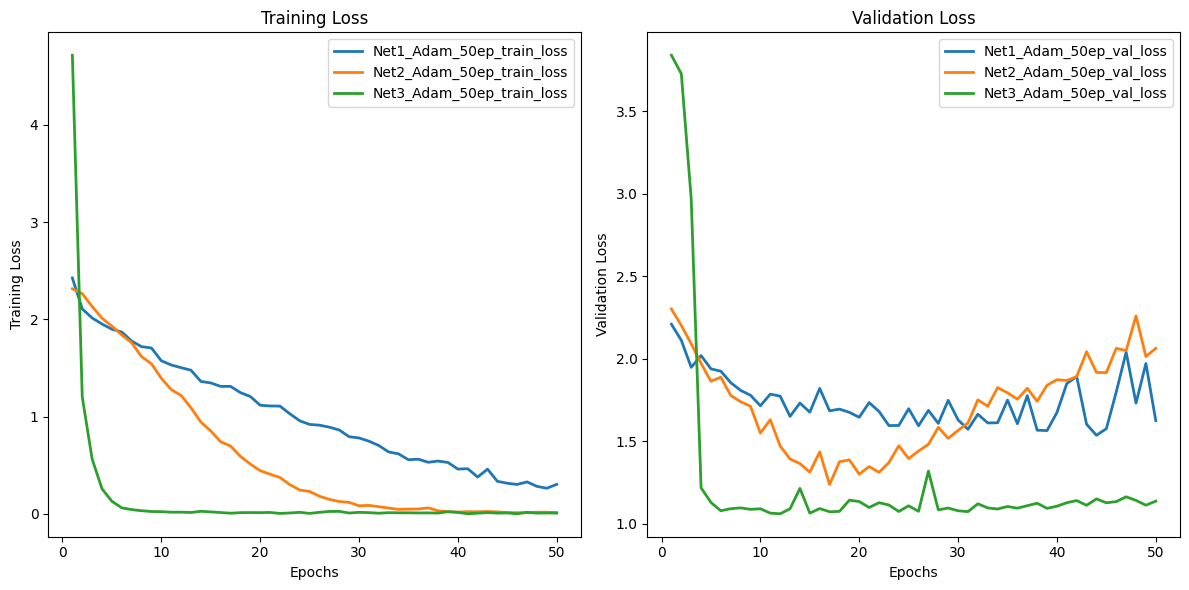

In [13]:
#result_arr14 meaning that the result for architecture 1 to 4
plot_history(results_1_4[1], accuracy=False, loss=True)

<Figure size 1200x600 with 0 Axes>

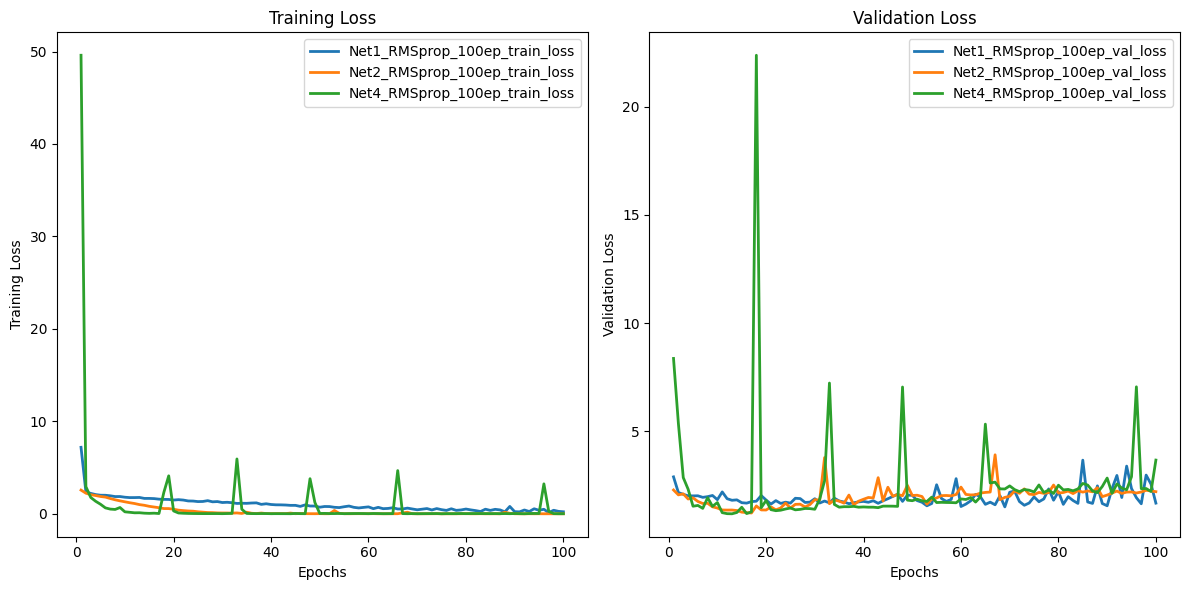

In [28]:
#result_arr14 meaning that the result for architecture 1 to 4
plot_history(results_1_4[2], accuracy=False, loss=True)

<Figure size 1200x600 with 0 Axes>

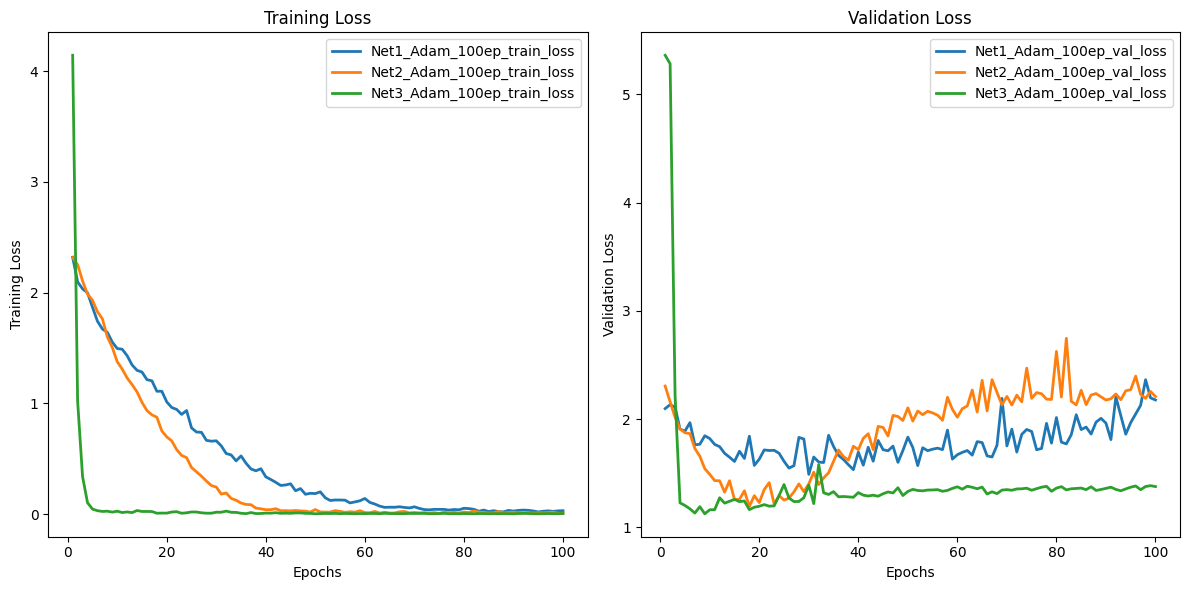

In [29]:
#result_arr14 meaning that the result for architecture 1 to 4
plot_history(results_1_4[3], accuracy=False, loss=True)

In [14]:
models = {
    'Net1' : Net1(
        input_size=3*180*180, 
        hidden_size1=512,
        hidden_size2=512,
        output_size=10,
    ),
    'Net2' : Net2(),
    'Net3' : Net3(),
    'Net4' : Net3()
}

model_dir = glob(f'checkpoints/*')
evaluate(model_dir, models, image_test_loaders)

[WARNING] Skipping unknown model architecture: 'Net6'
[WARNING] Skipping unknown model architecture: 'Net5'
[WARNING] Skipping unknown model architecture: 'Net5'
[INFO] Evaluation complete for model: Net3_Adam_epoch100.pt
              precision    recall  f1-score   support

           0       0.60      0.50      0.55        12
           1       0.62      0.91      0.74        11
           2       0.78      0.50      0.61        14
           3       0.71      0.86      0.77        14
           4       0.86      0.75      0.80         8
           5       0.71      0.62      0.67         8
           6       1.00      0.83      0.91         6
           7       1.00      0.83      0.91        12
           8       0.67      0.67      0.67         6
           9       0.50      0.70      0.58        10

    accuracy                           0.71       101
   macro avg       0.74      0.72      0.72       101
weighted avg       0.74      0.71      0.71       101

[WARNING] Skipping 

# 5-6 architecture

In [111]:
genre_dir = Path(BASE_DIR) / "genres_original"
genres = [p.name for p in genre_dir.iterdir() if p.is_dir()]
label_dict = {i : label for i, label in enumerate(genres)}
extractor = MFCCFeatureExtractor()
extractor.process_and_export_npy(audio_paths, "features.npy",'labels.npy', label_dict)

Processing audio files:  83%|████████▎ | 826/1000 [23:04<04:40,  1.61s/it]

[Load Error] /home/awr1u24/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/jazz/jazz.00054.wav: 


Processing audio files: 100%|██████████| 1000/1000 [27:55<00:00,  1.68s/it]


[INFO] Exported features to features.npy, labels to labels.npy


In [ ]:
genre_dir = Path(BASE_DIR) / "genres_original"
genres = [p.name for p in genre_dir.iterdir() if p.is_dir()]
label_dict = {i : label for i, label in enumerate(genres)}
extractor = MFCCFeatureExtractor()
extractor.process_and_export_npy(audio_paths, "features.npy",'labels.npy', label_dict)

Processing audio files:  83%|████████▎ | 826/1000 [23:04<04:40,  1.61s/it]

[Load Error] /home/awr1u24/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/jazz/jazz.00054.wav: 


Processing audio files: 100%|██████████| 1000/1000 [27:55<00:00,  1.68s/it]


[INFO] Exported features to features.npy, labels to labels.npy


In [2]:
# Load the features and labels from the exported .npy files
raw_features = np.load("features.npy", allow_pickle=True)
features = np.stack([f.astype(np.float32) for f in raw_features])
labels = np.load("labels.npy")
audio_dataset = AudioDataset(features, labels)
train_loaders, val_loaders, test_loaders = Loaders(audio_dataset, batch_size=32)

In [5]:

trainer = Trainer(
    train_loader=train_loaders,
    val_loader=val_loaders,
    device=torch.device("cuda"),
    save_dir=Path("./checkpoints"),
    early_stopping=True,
    patience=7
)

results_5 = trainer.train_models(
    models={
        "Net5": lambda: Net5(
            input_size=33, 
            hidden_size=512,
            dropout=0.3, #tried droput 0.5
        )
    },
    epochs=[100],
    optimizers=[
        (optim.Adam, {"lr":  0.0001}),
        (optim.RMSprop, {"lr": 0.0005}),
    ]
)

[INFO] Training: Net5 | Epochs: 100 | Optimizer: Adam | Config: {'lr': 0.0001}


Epoch 10/100 | Train Loss: 0.9041 | Train Acc: 0.6831 | Val Loss: 0.9534 | Val Acc: 0.6667


Epoch 20/100 | Train Loss: 0.5866 | Train Acc: 0.7916 | Val Loss: 0.7860 | Val Acc: 0.7347


Epoch 30/100 | Train Loss: 0.3956 | Train Acc: 0.8640 | Val Loss: 0.5841 | Val Acc: 0.8068


Epoch 40/100 | Train Loss: 0.2763 | Train Acc: 0.9055 | Val Loss: 0.5078 | Val Acc: 0.8368


[EARLY STOP] No improvement in 7 epochs. Stopping at epoch 43.
[INFO] Saved: checkpoints/Net5_Adam_epoch43.pt
[INFO] Training: Net5 | Epochs: 100 | Optimizer: RMSprop | Config: {'lr': 0.0005}


Epoch 10/100 | Train Loss: 1.0934 | Train Acc: 0.6022 | Val Loss: 1.0665 | Val Acc: 0.6031


Epoch 20/100 | Train Loss: 0.7372 | Train Acc: 0.7349 | Val Loss: 0.9259 | Val Acc: 0.6762


Epoch 30/100 | Train Loss: 0.4842 | Train Acc: 0.8243 | Val Loss: 0.6746 | Val Acc: 0.7658


Epoch 40/100 | Train Loss: 0.3085 | Train Acc: 0.8912 | Val Loss: 0.6117 | Val Acc: 0.7903


[EARLY STOP] No improvement in 7 epochs. Stopping at epoch 49.
[INFO] Saved: checkpoints/Net5_RMSprop_epoch49.pt


<Figure size 1200x600 with 0 Axes>

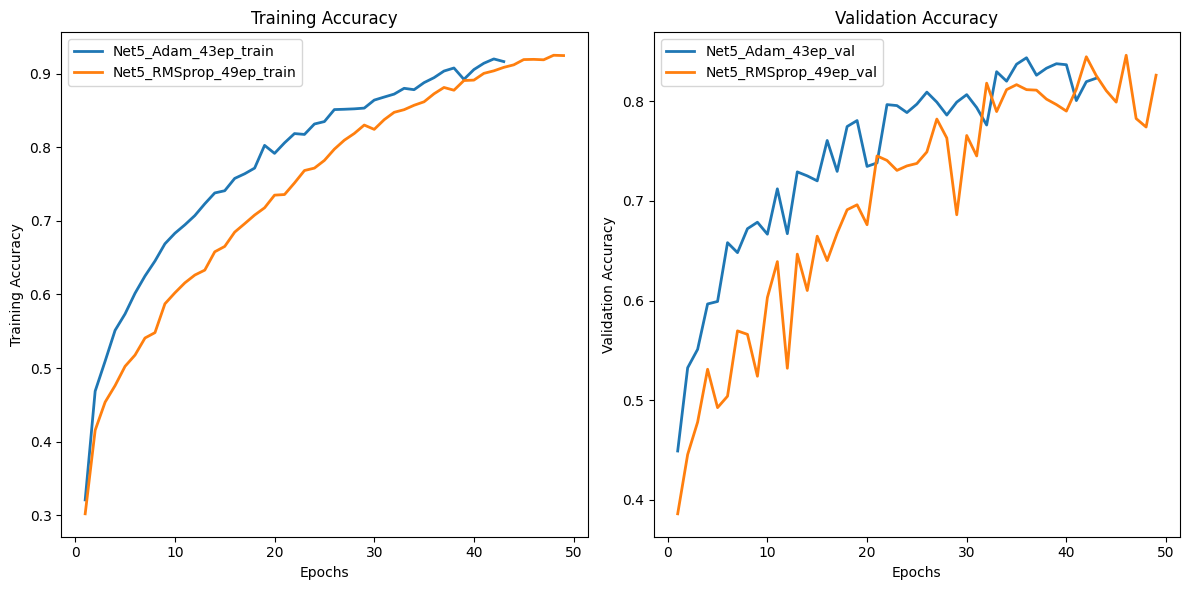

In [9]:
plot_history(results_5)

<Figure size 1200x600 with 0 Axes>

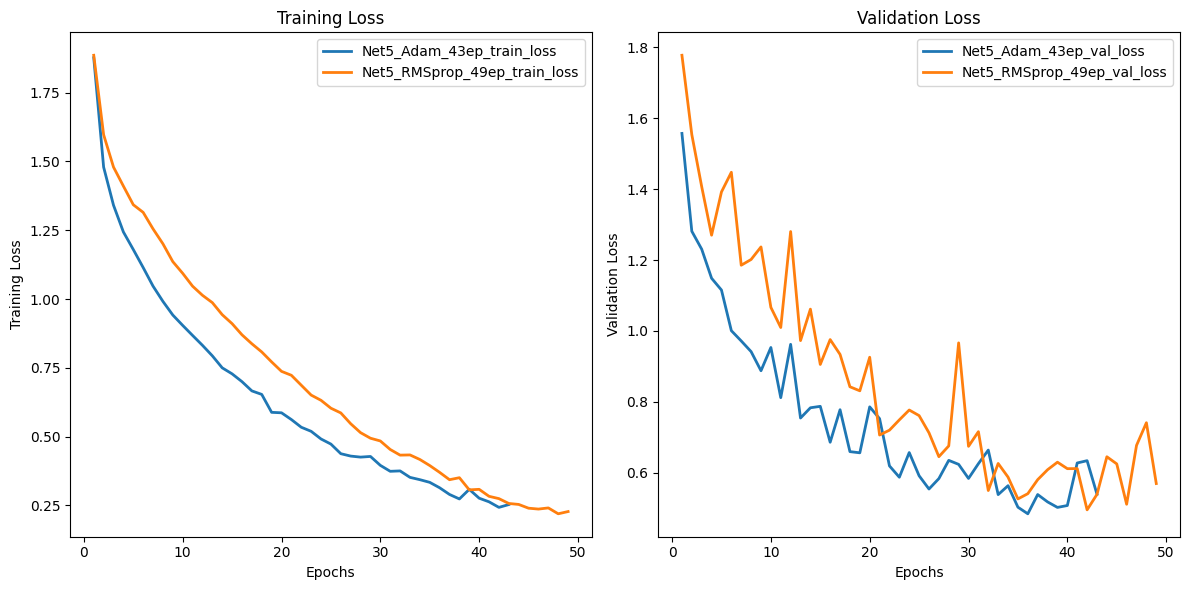

In [10]:
plot_history(results_5, accuracy=False, loss=True)

In [11]:
arc = Net5(
    input_size=33, 
    hidden_size=512,
    dropout=0.3,
)
model_dir_5 = glob('checkpoints/Net5*')
evaluate(model_dir_5, arc, test_loaders)

[INFO] Evaluation complete for model: Net5_Adam_epoch43.pt
              precision    recall  f1-score   support

           0       0.85      0.94      0.90       100
           1       0.73      0.83      0.78        96
           2       0.98      0.81      0.88       113
           3       0.85      0.78      0.81        90
           4       0.78      0.88      0.82       114
           5       0.98      0.79      0.87       105
           6       0.70      0.78      0.74        91
           7       0.94      0.96      0.95        85
           8       0.90      0.88      0.89       101
           9       0.85      0.84      0.84       104

    accuracy                           0.85       999
   macro avg       0.86      0.85      0.85       999
weighted avg       0.86      0.85      0.85       999

[INFO] Evaluation complete for model: Net5_RMSprop_epoch49.pt
              precision    recall  f1-score   support

           0       0.96      0.72      0.82       100
           

In [13]:
synthetic_features = np.load("wav_CGAN_features.npy", allow_pickle=True)
synthetic_labels = np.load("wav_CGAN_labels.npy")
audio_synthetic = AudioDataset(synthetic_features, synthetic_labels)
synthetic_train_loaders, sythentic_val_loaders, sythentic_test_loaders = Loaders(audio_synthetic, batch_size=32)

In [14]:

trainer = Trainer(
    train_loader=synthetic_train_loaders,
    val_loader=sythentic_val_loaders,
    device=torch.device("cuda"),
    save_dir=Path("./checkpoints"),
    early_stopping=True,
    patience=10
)

results_6 = trainer.train_models(
    models={
        "Net6": lambda: Net5(
            input_size=33, 
            hidden_size=512,
            dropout=0.3,
        )
    },
    epochs=[400],
    optimizers=[
        (optim.Adam, {"lr":  0.0001}),
        (optim.RMSprop, {"lr": 0.0005}),
    ]
)

[INFO] Training: Net6 | Epochs: 400 | Optimizer: Adam | Config: {'lr': 0.0001}


Epoch 1/400 [Train]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 10/400 | Train Loss: 1.3355 | Train Acc: 0.4923 | Val Loss: 1.3304 | Val Acc: 0.4925


Epoch 20/400 | Train Loss: 0.9860 | Train Acc: 0.6331 | Val Loss: 1.0938 | Val Acc: 0.6091


Epoch 30/400 | Train Loss: 0.8081 | Train Acc: 0.6966 | Val Loss: 0.9061 | Val Acc: 0.6657


Epoch 40/400 | Train Loss: 0.6818 | Train Acc: 0.7455 | Val Loss: 0.8359 | Val Acc: 0.6994


Epoch 50/400 | Train Loss: 0.6221 | Train Acc: 0.7668 | Val Loss: 0.7083 | Val Acc: 0.7515


Epoch 60/400 | Train Loss: 0.5566 | Train Acc: 0.7899 | Val Loss: 0.6744 | Val Acc: 0.7658


Epoch 70/400 | Train Loss: 0.5011 | Train Acc: 0.8124 | Val Loss: 0.6998 | Val Acc: 0.7650


[EARLY STOP] No improvement in 10 epochs. Stopping at epoch 77.
[INFO] Saved: checkpoints/Net6_Adam_epoch77.pt
[INFO] Training: Net6 | Epochs: 400 | Optimizer: RMSprop | Config: {'lr': 0.0005}


Epoch 10/400 | Train Loss: 1.4857 | Train Acc: 0.4308 | Val Loss: 1.4132 | Val Acc: 0.4489


Epoch 20/400 | Train Loss: 1.0886 | Train Acc: 0.5902 | Val Loss: 1.1316 | Val Acc: 0.5701


Epoch 30/400 | Train Loss: 0.8420 | Train Acc: 0.6905 | Val Loss: 0.7972 | Val Acc: 0.7035


Epoch 40/400 | Train Loss: 0.6787 | Train Acc: 0.7480 | Val Loss: 0.7069 | Val Acc: 0.7490


Epoch 50/400 | Train Loss: 0.5854 | Train Acc: 0.7778 | Val Loss: 0.6890 | Val Acc: 0.7530


[EARLY STOP] No improvement in 10 epochs. Stopping at epoch 51.
[INFO] Saved: checkpoints/Net6_RMSprop_epoch51.pt


<Figure size 1200x600 with 0 Axes>

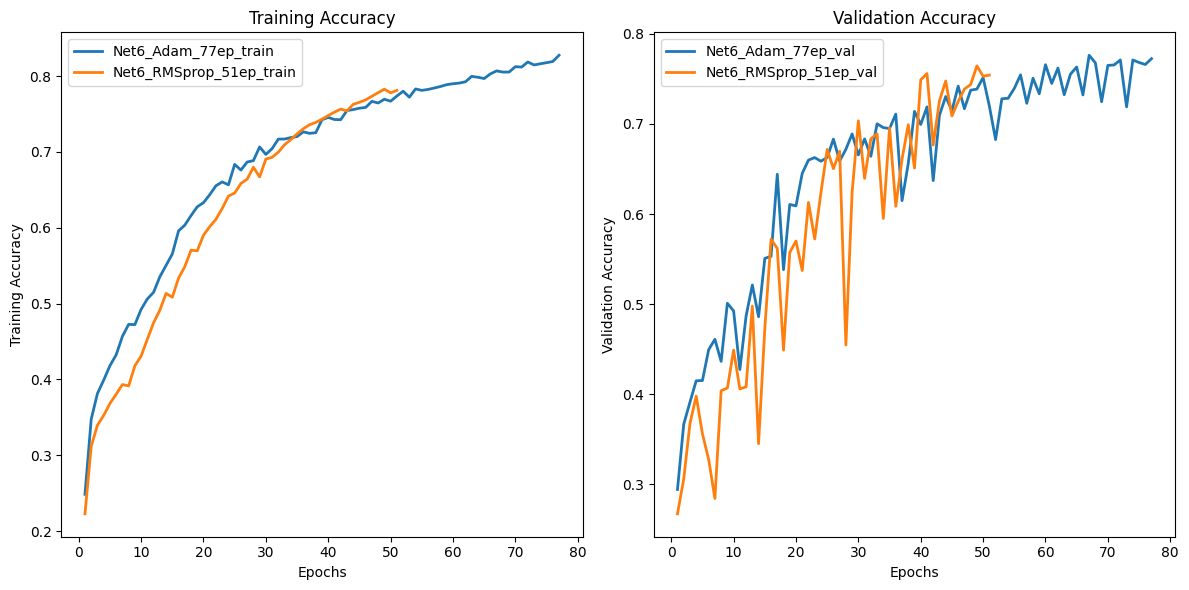

In [15]:
plot_history(results_6)

<Figure size 1200x600 with 0 Axes>

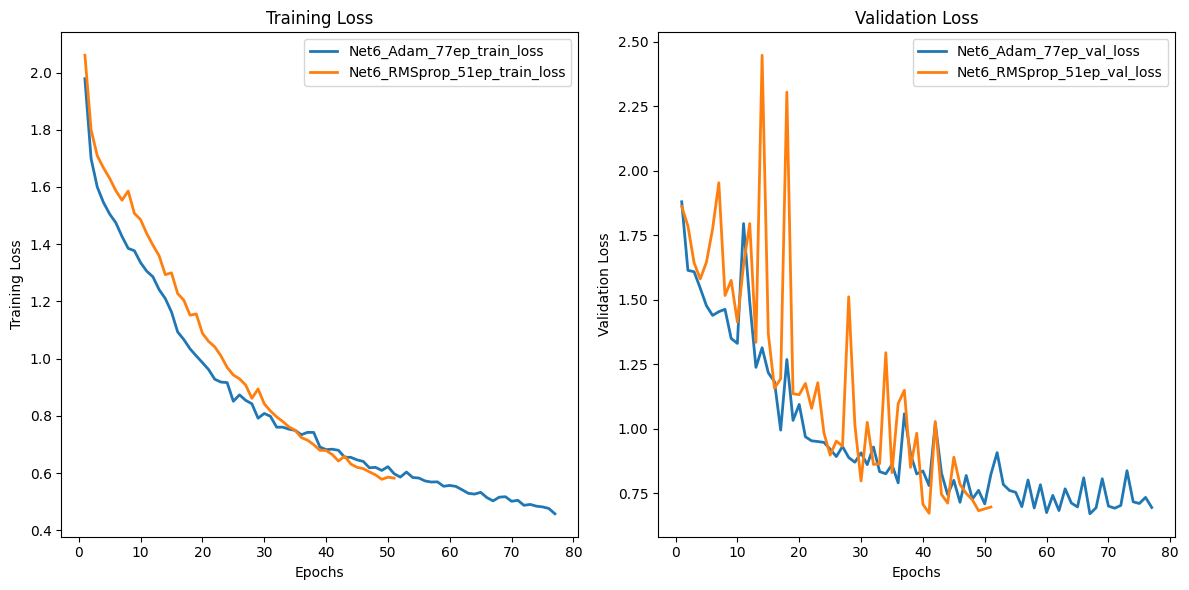

In [16]:
plot_history(results_6, accuracy=False, loss=True)

In [18]:
model_dir_6 = glob('checkpoints/Net6*')
evaluate(model_dir_6, arc, sythentic_test_loaders)

[INFO] Evaluation complete for model: Net6_RMSprop_epoch51.pt
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       204
           1       0.72      0.91      0.80       180
           2       0.69      0.47      0.56       203
           3       0.61      0.73      0.67       196
           4       0.81      0.85      0.83       216
           5       0.60      0.74      0.66       182
           6       0.58      0.40      0.47       205
           7       0.96      0.95      0.95       213
           8       0.91      0.88      0.89       209
           9       0.88      0.81      0.84       190

    accuracy                           0.76      1998
   macro avg       0.75      0.76      0.75      1998
weighted avg       0.76      0.76      0.75      1998

[INFO] Evaluation complete for model: Net6_Adam_epoch77.pt
              precision    recall  f1-score   support

           0       0.83      0.91      0.86       204
           

In [8]:
mfcc_features = np.load("mfcc_CGAN_features.npy", allow_pickle=True)
mfcc_labels = np.load("mfcc_CGAN_labels.npy")
audio_synthetic = AudioDataset(mfcc_features, mfcc_labels)
synthetic_train_loaders, sythentic_val_loaders, sythentic_test_loaders = Loaders(audio_synthetic, batch_size=32)

In [10]:

trainer = Trainer(
    train_loader=synthetic_train_loaders,
    val_loader=sythentic_val_loaders,
    device=torch.device("cuda"),
    save_dir=Path("./checkpoints"),
    early_stopping=True,
    patience=7
)

results_6 = trainer.train_models(
    models={
        "Net6": lambda: Net5(
            input_size=33, 
            hidden_size=512,
            dropout=0.3,
        )
    },
    epochs=[400],
    optimizers=[
        (optim.Adam, {"lr":  0.0001}),
        (optim.RMSprop, {"lr": 0.0005}),
    ]
)

[INFO] Training: Net6 | Epochs: 400 | Optimizer: Adam | Config: {'lr': 0.0001}


Epoch 10/400 | Train Loss: 0.4928 | Train Acc: 0.8225 | Val Loss: 0.5076 | Val Acc: 0.8146


Epoch 20/400 | Train Loss: 0.3436 | Train Acc: 0.8792 | Val Loss: 0.3745 | Val Acc: 0.8714


Epoch 30/400 | Train Loss: 0.2273 | Train Acc: 0.9219 | Val Loss: 0.3232 | Val Acc: 0.8921


Epoch 40/400 | Train Loss: 0.1554 | Train Acc: 0.9474 | Val Loss: 0.2675 | Val Acc: 0.9197


Epoch 50/400 | Train Loss: 0.1405 | Train Acc: 0.9537 | Val Loss: 0.2567 | Val Acc: 0.9184
[EARLY STOP] No improvement in 7 epochs. Stopping at epoch 50.
[INFO] Saved: checkpoints/Net6_Adam_epoch50.pt
[INFO] Training: Net6 | Epochs: 400 | Optimizer: RMSprop | Config: {'lr': 0.0005}


Epoch 10/400 | Train Loss: 0.5475 | Train Acc: 0.8027 | Val Loss: 0.7588 | Val Acc: 0.7237


Epoch 20/400 | Train Loss: 0.3521 | Train Acc: 0.8762 | Val Loss: 0.3854 | Val Acc: 0.8656


Epoch 30/400 | Train Loss: 0.2572 | Train Acc: 0.9130 | Val Loss: 0.6405 | Val Acc: 0.8073


Epoch 40/400 | Train Loss: 0.1295 | Train Acc: 0.9559 | Val Loss: 0.2781 | Val Acc: 0.9177


Epoch 50/400 | Train Loss: 0.1002 | Train Acc: 0.9666 | Val Loss: 0.3197 | Val Acc: 0.9119


Epoch 60/400 | Train Loss: 0.0938 | Train Acc: 0.9725 | Val Loss: 0.3107 | Val Acc: 0.9209
[EARLY STOP] No improvement in 7 epochs. Stopping at epoch 60.
[INFO] Saved: checkpoints/Net6_RMSprop_epoch60.pt
